In [2]:
import transformers, peft, datasets, torch, accelerate

print("transformers:", transformers.__version__)
print("peft:", peft.__version__)
print("datasets:", datasets.__version__)
print("torch:", torch.__version__)
print("accelerate:", accelerate.__version__)
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import torch

transformers: 4.56.2
peft: 0.7.1
datasets: 4.1.1
torch: 2.5.1
accelerate: 1.10.1



In [1]:
#train the gpt-based model (llama-lora) and save it
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
import torch
from sklearn.model_selection import train_test_split

# -----------------------------
# 1 Config
# --------------- 
CSV_PATH   = "001_2802_merged_12000.csv"
TEXT_COL   = "text"
LABEL_COL  = "label"
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
OUTPUT_DIR = "./llama_lora_clean"
EPOCHS     = 2   # train a bit longer
BATCH_SIZE = 2

# -----------------------------
# 2 Prompt template
# ----------------------- 
PROMPT_TEMPLATE = (
    "You are a clinical assistant. Classify the text for depression risk.\n"
    "Return ONLY a single digit: 1 if depressed, 0 if not depressed.\n"
    "Do not write any other words.\n\n"
    "Text: {text}\n\n"
    "Answer:"
)

def build_prompt(text, label):
    return PROMPT_TEMPLATE.format(text=text.strip()) + f" {int(label)}"

# -----------------------------
# Load and split dataset
# ---------------- 
df = pd.read_csv(CSV_PATH)

train_val_df, test_df = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df[LABEL_COL]
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, random_state=42, stratify=train_val_df[LABEL_COL]
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
test_df.to_csv("test_split.csv", index=False)

train_df["train_text"] = train_df.apply(lambda r: build_prompt(r[TEXT_COL], r[LABEL_COL]), axis=1)
val_df["train_text"]   = val_df.apply(lambda r: build_prompt(r[TEXT_COL], r[LABEL_COL]), axis=1)

train_dataset = Dataset.from_pandas(train_df[["train_text"]])
val_dataset   = Dataset.from_pandas(val_df[["train_text"]])

# -----------------------------
# 3 Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def preprocess(batch):
    enc = tokenizer(
        batch["train_text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    enc["labels"] = enc["input_ids"].copy()
    return enc

train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["train_text"])
val_dataset   = val_dataset.map(preprocess, batched=True, remove_columns=["train_text"])

# -----------------------------
# 4 Model + LoRA
# --------------------- 
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

# -----------------------------
# 5 Training
# --------------------- 
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()
trainer.save_model(OUTPUT_DIR)



Train: 6406, Val: 800, Test: 801


Map:   0%|          | 0/6406 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2276\107858964.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss
10,11.954500
20,2.964700
30,0.859400
40,0.521700
50,0.369500
60,0.337000
70,0.307100
80,0.335900
90,0.351800
100,0.291900


In [3]:
#Test the saved model
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

# -----------------------------
# 1 Config
# ------------------- 
MODEL_PATH = "./llama_lora_clean"
TEST_PATH  = "test_split.csv"
TEXT_COL   = "text"
LABEL_COL  = "label"

PROMPT_TEMPLATE = (
    "You are a clinical assistant. Classify the text for depression risk.\n"
    "Return ONLY a single digit: 1 if depressed, 0 if not depressed.\n"
    "Do not write any other words.\n\n"
    "Text: {text}\n\n"
    "Answer:"
)

# -----------------------------
# 2 Load model + tokenizer
# ------------------- 
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model     = AutoModelForCausalLM.from_pretrained(MODEL_PATH)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ------------------ 
# 3 Load test set
# --------------- 
df_test = pd.read_csv(TEST_PATH)

# -----------------------------
# 4 Prediction function
# --------------------- 
def classify(text):
    prompt = PROMPT_TEMPLATE.format(text=text.strip())
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=2,
            temperature=0.0,
            do_sample=False
        )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract last digit (0 or 1)
    if "1" in decoded[-5:]:
        return 1
    else:
        return 0

# -----------------------------
# 5 Run predictions
# --------------------- 
y_true = df_test[LABEL_COL].tolist()
y_pred = [classify(t) for t in df_test[TEXT_COL].tolist()]

# -----------------------------
# 6 Evaluation Metrics
# ------------ 
acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

try:
    auc = roc_auc_score(y_true, y_pred)
except ValueError:
    auc = float("nan")

cm = confusion_matrix(y_true, y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("AUC      :", auc)
print("Confusion matrix:\n", cm)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Accuracy : 0.6579275905118602
Precision: 0.5991561181434599
Recall   : 0.7717391304347826
F1       : 0.6745843230403801
AUC      : 0.6664700271111557
Confusion matrix:
 [[243 190]
 [ 84 284]]


In [6]:
# save_embeddings 
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# -----------------------------
# Config
# -----------------------------
MODEL_PATH = "./llama_lora_clean"
CSV_PATH   = "001_2802_merged_12000.csv"
TEXT_COL   = "text"
LABEL_COL  = "label"
MAX_LEN    = 128
EMB_PATH   = "embeddings_split.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Load model + tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model     = AutoModelForCausalLM.from_pretrained(MODEL_PATH, output_hidden_states=True).to(device)
model.eval()

# -----------------------------
# Dataset split (80/10/10)
# -----------------------------
df = pd.read_csv(CSV_PATH)

train_val_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df[LABEL_COL], random_state=42
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.111, stratify=train_val_df[LABEL_COL], random_state=42
)
# ~80% train, ~10% val, ~10% test

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]
        emb = hidden_states.mean(dim=1).squeeze(0)  # mean pooling
    return emb.cpu()

print("Extracting embeddings...")
X_train = torch.stack([get_embedding(t) for t in tqdm(train_df[TEXT_COL], desc="Train embeddings")])
y_train = torch.tensor(train_df[LABEL_COL].values, dtype=torch.long)

X_val = torch.stack([get_embedding(t) for t in tqdm(val_df[TEXT_COL], desc="Val embeddings")])
y_val = torch.tensor(val_df[LABEL_COL].values, dtype=torch.long)

X_test = torch.stack([get_embedding(t) for t in tqdm(test_df[TEXT_COL], desc="Test embeddings")])
y_test = torch.tensor(test_df[LABEL_COL].values, dtype=torch.long)

torch.save({
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
    "X_test": X_test,
    "y_test": y_test
}, EMB_PATH)

print(f"Embeddings saved to {EMB_PATH}")


Extracting embeddings...


Test embeddings: 100%|███████████████████████████████████████████████████████████████| 801/801 [03:01<00:00,  4.42it/s]

Embeddings saved to embeddings_split.pt


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19728\3655227430.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(EMB_PATH)
Epoch 1/30: 100%|██████

Epoch 1/30 | Loss: 0.6122 | Val Acc: 0.6825, Prec: 0.6215, Recall: 0.7875, F1: 0.6947


Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 393.17it/s]


Epoch 2/30 | Loss: 0.5525 | Val Acc: 0.7137, Prec: 0.6816, Recall: 0.7057, F1: 0.6934


Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 397.42it/s]


Epoch 3/30 | Loss: 0.5161 | Val Acc: 0.7200, Prec: 0.7049, Recall: 0.6703, F1: 0.6872


Epoch 4/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 406.23it/s]


Epoch 4/30 | Loss: 0.4856 | Val Acc: 0.6550, Prec: 0.7630, Recall: 0.3597, F1: 0.4889


Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 395.76it/s]


Epoch 5/30 | Loss: 0.4552 | Val Acc: 0.7262, Prec: 0.6682, Recall: 0.8011, F1: 0.7286


Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 405.57it/s]


Epoch 6/30 | Loss: 0.4196 | Val Acc: 0.7512, Prec: 0.7386, Recall: 0.7084, F1: 0.7232


Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 385.80it/s]


Epoch 7/30 | Loss: 0.3844 | Val Acc: 0.7550, Prec: 0.7090, Recall: 0.7902, F1: 0.7474


Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 422.88it/s]


Epoch 8/30 | Loss: 0.3405 | Val Acc: 0.7775, Prec: 0.7288, Recall: 0.8202, F1: 0.7718


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 404.16it/s]


Epoch 9/30 | Loss: 0.3111 | Val Acc: 0.7863, Prec: 0.7159, Recall: 0.8856, F1: 0.7917


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 420.65it/s]


Epoch 10/30 | Loss: 0.2800 | Val Acc: 0.7963, Prec: 0.7802, Recall: 0.7738, F1: 0.7770


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 418.11it/s]


Epoch 11/30 | Loss: 0.2596 | Val Acc: 0.8013, Prec: 0.7419, Recall: 0.8692, F1: 0.8005


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 410.24it/s]


Epoch 12/30 | Loss: 0.2322 | Val Acc: 0.8000, Prec: 0.7966, Recall: 0.7575, F1: 0.7765


Epoch 13/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 406.30it/s]


Epoch 13/30 | Loss: 0.2047 | Val Acc: 0.7987, Prec: 0.7500, Recall: 0.8420, F1: 0.7933


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 395.57it/s]


Epoch 14/30 | Loss: 0.1913 | Val Acc: 0.8025, Prec: 0.7209, Recall: 0.9292, F1: 0.8119


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 400.90it/s]


Epoch 15/30 | Loss: 0.1733 | Val Acc: 0.8175, Prec: 0.7931, Recall: 0.8147, F1: 0.8038


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 408.06it/s]


Epoch 16/30 | Loss: 0.1640 | Val Acc: 0.7963, Prec: 0.7125, Recall: 0.9319, F1: 0.8076


Epoch 17/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 416.57it/s]


Epoch 17/30 | Loss: 0.1466 | Val Acc: 0.8300, Prec: 0.7895, Recall: 0.8583, F1: 0.8225


Epoch 18/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 424.54it/s]


Epoch 18/30 | Loss: 0.1291 | Val Acc: 0.8225, Prec: 0.7622, Recall: 0.8910, F1: 0.8216


Epoch 19/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 401.48it/s]


Epoch 19/30 | Loss: 0.1314 | Val Acc: 0.8387, Prec: 0.8020, Recall: 0.8610, F1: 0.8305


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 422.85it/s]


Epoch 20/30 | Loss: 0.1401 | Val Acc: 0.8313, Prec: 0.7613, Recall: 0.9210, F1: 0.8335


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 411.04it/s]


Epoch 21/30 | Loss: 0.1067 | Val Acc: 0.8313, Prec: 0.8204, Recall: 0.8093, F1: 0.8148


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 422.31it/s]


Epoch 22/30 | Loss: 0.1089 | Val Acc: 0.8375, Prec: 0.8376, Recall: 0.8011, F1: 0.8189


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 406.86it/s]


Epoch 23/30 | Loss: 0.0894 | Val Acc: 0.8538, Prec: 0.8019, Recall: 0.9046, F1: 0.8502


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 386.26it/s]


Epoch 24/30 | Loss: 0.1037 | Val Acc: 0.8413, Prec: 0.8000, Recall: 0.8719, F1: 0.8344


Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 419.92it/s]


Epoch 25/30 | Loss: 0.0893 | Val Acc: 0.8450, Prec: 0.7985, Recall: 0.8856, F1: 0.8398


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:01<00:00, 411.11it/s]


Epoch 26/30 | Loss: 0.0898 | Val Acc: 0.8287, Prec: 0.7590, Recall: 0.9183, F1: 0.8311


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 382.39it/s]


Epoch 27/30 | Loss: 0.0945 | Val Acc: 0.8313, Prec: 0.7578, Recall: 0.9292, F1: 0.8348


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 381.86it/s]


Epoch 28/30 | Loss: 0.0649 | Val Acc: 0.8087, Prec: 0.8474, Recall: 0.7112, F1: 0.7733


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 373.39it/s]


Epoch 29/30 | Loss: 0.0844 | Val Acc: 0.8650, Prec: 0.8151, Recall: 0.9128, F1: 0.8612


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████| 801/801 [00:02<00:00, 395.19it/s]


Epoch 30/30 | Loss: 0.0710 | Val Acc: 0.8625, Prec: 0.8320, Recall: 0.8774, F1: 0.8541
Classifier saved to mlp_classifier.pt


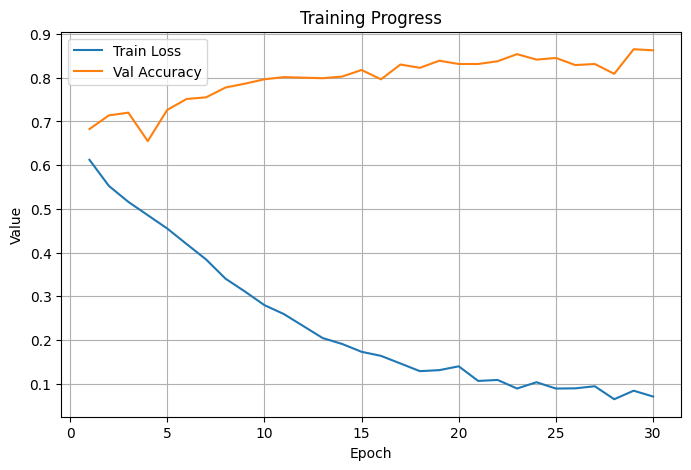

In [10]:
# train_classifier 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
EMB_PATH = "embeddings_split.pt"
BATCH_SIZE = 8
EPOCHS     = 30
LR         = 1e-3
MODEL_SAVE = "mlp_classifier.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Load embeddings
# -----------------------------
data = torch.load(EMB_PATH)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"], data["y_val"]

# -----------------------------
# Classifier
# -----------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

input_dim = X_train.shape[1]
clf = MLPClassifier(input_dim).to(device)

# -----------------------------
# Training
# -------------- --
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=LR)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    clf.train()
    total_loss = 0
    
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = clf(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation check
    clf.eval()
    with torch.no_grad():
        preds = clf(X_val.to(device)).argmax(dim=1).cpu()
    
    acc = accuracy_score(y_val, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_val, preds, average="binary", zero_division=0)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | "
          f"Val Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# -----------------------------
# Save Classifier
# ---------------- -
torch.save(clf.state_dict(), MODEL_SAVE)
print(f"Classifier saved to {MODEL_SAVE}")

# -----------------------------
# Plot
# ------------ 
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# test_classifier 
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# -----------------------------
# Config
# -----------------------------
EMB_PATH = "embeddings_split.pt"
MODEL_SAVE = "mlp_classifier.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Load embeddings
# -----------------------------
data = torch.load(EMB_PATH)
X_test, y_test = data["X_test"], data["y_test"]

# -----------------------------
# Define MLP (must match training)
# -----------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

input_dim = X_test.shape[1]
clf = MLPClassifier(input_dim).to(device)
clf.load_state_dict(torch.load(MODEL_SAVE))
clf.eval()

# -----------------------------
# Final Evaluation
# -----------------------------
with torch.no_grad():
    preds = clf(X_test.to(device)).argmax(dim=1).cpu()

acc = accuracy_score(y_test, preds)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary", zero_division=0)
cm = confusion_matrix(y_test, preds)

print("\nFinal Test Evaluation (Unseen Test Set):")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("Confusion Matrix:\n", cm)



Final Test Evaluation (Unseen Test Set):
Accuracy : 0.8626716604244694
Precision: 0.8307692307692308
Recall   : 0.8804347826086957
F1       : 0.8548812664907651
Confusion Matrix:
 [[367  66]
 [ 44 324]]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19728\1201666541.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(EMB_PATH)
C:\Users\Administrator\